# Accelerate BERT Inference with Hugging Face Transformers and AWS inferentia

In this end-to-end tutorial, you will learn how to speed up BERT inference for text classification with Hugging Face Transformers, Amazon SageMaker, and AWS Inferentia. 

You will learn how to: 

1. Convert your Hugging Face Transformer to AWS Neuron (Inferentia)
2. Create a custom `inference.py` script for `text-classification`
3. Create and upload the neuron model and inference script to Amazon S3
4. Deploy a Real-time Inference Endpoint on Amazon SageMaker
5. Run and evaluate Inference performance of BERT on Inferentia

Let's get started! 🚀

---

*If you are going to use Sagemaker in a local environment (not SageMaker Studio or Notebook Instances). You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it.*

# 1. Convert your Hugging Face Transformer to AWS Neuron

We are going to use the [AWS Neuron SDK for AWS Inferentia](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/index.html). The Neuron SDK includes a deep learning compiler, runtime, and tools for converting and compiling PyTorch and TensorFlow models to neuron compatible models, which can be run on [EC2 Inf1 instances](https://aws.amazon.com/ec2/instance-types/inf1/). 

As a first step, we need to install the [Neuron SDK](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-intro/neuron-install-guide.html) and the required packages.

*Tip: If you are using Amazon SageMaker Notebook Instances or Studio you can go with the `conda_python3` conda kernel.*


In [ ]:
# Set Pip repository  to point to the Neuron repository
!pip config set global.extra-index-url https://pip.repos.neuron.amazonaws.com

# Install Neuron PyTorch
!pip install torch-neuron==1.9.1.* neuron-cc[tensorflow] sagemaker>=2.79.0 transformers==4.12.3 datasets --upgrade

After we have installed the Neuron SDK we can convert load and convert our model. Neuron models are converted using `torch_neuron` with its `trace` method similar to `torchscript`. You can find more information in our [documentation](https://huggingface.co/docs/transformers/serialization#torchscript).

To be able to convert our model we first need to select the model we want to use for our text classification pipeline from [hf.co/models](http://hf.co/models). For this example lets go with [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) but this can be easily adjusted with other BERT-like models.

In [1]:
model_id = "optimum/MiniLMv2-L12-H384-distilled-finetuned-clinc"

At the time of writing, the [AWS Neuron SDK does not support dynamic shapes](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/models/models-inferentia.html#dynamic-shapes), which means that the input size needs to be static for compiling and inference. 

In simpler terms, this means when the model is compiled with an input of batch size 1 and sequence length of 16. The model can only run inference on inputs with the same shape.

_When using a `t2.medium` instance the compiling takes around 2-3 minutes_ 

In [7]:
import os
import tensorflow  # to workaround a protobuf version conflict issue
import torch
import torch.neuron
from transformers import AutoTokenizer, AutoModelForSequenceClassification


# load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id, torchscript=True)

# create dummy input for max length 128
dummy_input = "dummy input which will be padded later"
max_length = 128
embeddings = tokenizer(dummy_input, max_length=max_length, padding="max_length",return_tensors="pt")
neuron_inputs = tuple(embeddings.values())

# compile model with torch.neuron.trace and update config
model_neuron = torch.neuron.trace(model, neuron_inputs)
model.config.update({"traced_sequence_length": max_length})

# save tokenizer, neuron model and config for later use
save_dir="tmp"
os.makedirs("tmp",exist_ok=True)
model_neuron.save(os.path.join(save_dir,"neuron_model.pt"))
tokenizer.save_pretrained(save_dir)
model.config.save_pretrained(save_dir)

Couldn't call 'get_role' to get Role ARN from role name philippschmid to get Role path.


sagemaker role arn: arn:aws:iam::558105141721:role/sagemaker_execution_role
sagemaker bucket: sagemaker-us-east-1-558105141721
sagemaker session region: us-east-1


In [ ]:
import os

# get model file size
size = os.path.getsize(os.path.join(save_dir,"neuron_model.pt"))/(1024*1024)

print(f"Model file size: {size:.2f} MB")

# 2. Create a custom inference.py script for text-classification

The [Hugging Face Inference Toolkit](https://github.com/aws/sagemaker-huggingface-inference-toolkit) supports zero-code deployments on top of the [pipeline feature](https://huggingface.co/transformers/main_classes/pipelines.html) from 🤗 Transformers. This allows users to deploy Hugging Face transformers without an inference script [[Example](https://github.com/huggingface/notebooks/blob/master/sagemaker/11_deploy_model_from_hf_hub/deploy_transformer_model_from_hf_hub.ipynb)]. 

Currently is this feature not supported with AWS Inferentia, which means we need to provide an `inference.py` for running inference. 

*If you would be interested in support for zero-code deployments for inferentia let us know on the [forum](https://discuss.huggingface.co/c/sagemaker/17).*

---

To use the inference script, we need to create an `inference.py` script. In our example, we are going to overwrite the `model_fn` to load our neuron model and the `predict_fn` to create a text-classification pipeline. 

If you want to know more about the `inference.py` script check out this [example](https://github.com/huggingface/notebooks/blob/master/sagemaker/17_custom_inference_script/sagemaker-notebook.ipynb). It explains amongst other things what the `model_fn` and `predict_fn` are.

In [17]:
!mkdir code

We are using the `NEURON_RT_NUM_CORES=1` to make sure that each HTTP worker uses 1 Neuron core to maximize throughput.

In [38]:
%%writefile code/inference.py

import os
from transformers import AutoConfig, AutoTokenizer
import torch
import torch.neuron

# To use one neuron core per worker
os.environ["NEURON_RT_NUM_CORES"] = "1"

# saved weights name
AWS_NEURON_TRACED_WEIGHTS_NAME = "neuron_model.pt"


def model_fn(model_dir):
    # load tokenizer and neuron model from model_dir
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = torch.jit.load(os.path.join(model_dir, AWS_NEURON_TRACED_WEIGHTS_NAME))
    model_config = AutoConfig.from_pretrained(model_dir)

    return model, tokenizer, model_config


def predict_fn(data, model_tokenizer_model_config):
    # destruct model, tokenizer and model config
    model, tokenizer, model_config = model_tokenizer_model_config

    # create embeddings for inputs
    inputs = data.pop("inputs", data)
    embeddings = tokenizer(
        inputs,
        return_tensors="pt",
        max_length=model_config.traced_sequence_length,
        padding="max_length",
        truncation=True,
    )
    # convert to tuple for neuron model
    neuron_inputs = tuple(embeddings.values())

    # run prediciton
    with torch.no_grad():
        predictions = model(*neuron_inputs)[0]
        scores = torch.nn.Softmax(dim=1)(predictions)

    # return dictonary, which will be json serializable
    return [{"label": model_config.id2label[item.argmax().item()], "score": item.max().item()} for item in scores]

Overwriting code/inference.py


# 3. Create and upload the neuron model and inference script to Amazon S3

Before we can deploy our neuron model to Amazon SageMaker we need to create a `model.tar.gz` archive with all our model artifacts saved into `tmp/`, e.g. `neuron_model.pt` and upload this to Amazon S3.

To do this we need to set up our permissions.

In [39]:
import sagemaker
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

Next, we create our `model.tar.gz`.The `inference.py` script will be placed into a `code/` folder.

In [ ]:
# copy inference.py into the code/ directory of the model directory.
!cp -r code/ tmp/code/
# create a model.tar.gz archive with all the model artifacts and the inference.py script.
%cd tmp
!tar zcvf model.tar.gz *
%cd ..

Now we can upload our `model.tar.gz` to our session S3 bucket with `sagemaker`.

In [41]:
from sagemaker.s3 import S3Uploader

# create s3 uri
s3_model_path = f"s3://{sess.default_bucket()}/{model_id}"

# upload model.tar.gz
s3_model_uri = S3Uploader.upload(local_path="tmp/model.tar.gz",desired_s3_uri=s3_model_path)
print(f"model artifcats uploaded to {s3_model_uri}")

# 4. Deploy a Real-time Inference Endpoint on Amazon SageMaker

After we have uploaded our `model.tar.gz` to Amazon S3 can we create a custom `HuggingfaceModel`. This class will be used to create and deploy our real-time inference endpoint on Amazon SageMaker.

In [ ]:
from sagemaker.huggingface.model import HuggingFaceModel


# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data=s3_model_uri,       # path to your model and script
   role=role,                    # iam role with permissions to create an Endpoint
   transformers_version="4.12",  # transformers version used
   pytorch_version="1.9",        # pytorch version used
   py_version='py37',            # python version used
)

# Let SageMaker know that we've already compiled the model via neuron-cc
huggingface_model._is_compiled_model = True

# deploy the endpoint endpoint
predictor = huggingface_model.deploy(
    initial_instance_count=1,      # number of instances
    instance_type="ml.inf1.xlarge" # AWS Inferentia Instance
)

# 5. Run and evaluate Inference performance of BERT on Inferentia

The `.deploy()` returns an `HuggingFacePredictor` object which can be used to request inference.

In [ ]:
data = {
  "inputs": "the mesmerizing performances of the leads keep the film grounded and keep the audience riveted .",
}

res = predictor.predict(data=data)
res

In [ ]:
from datasets import load_dataset,load_metric

metric = load_metric("accuracy")
dataset = load_dataset(dataset_id,dataset_config,split=["validation"])[0]

def evaluate(example):
  neuron = predictor.predict(data=example["sentence"]) 
  return {"neuron":neuron_clx.model.config.label2id[neuron[0]["label"]]}

result = dataset.map(evaluate)

neuron_acc = metric.compute(predictions=result["neuron"], references=result["label"])["accuracy"]
print(f"neuron accuracy: {round(neuron_acc,4)*100}%")

We managed to deploy our neuron compiled BERT to AWS Inferentia on Amazon SageMaker. Now, let's test its performance of it. As a dummy load test will we loop and send 10000 synchronous requests to our endpoint.

In [ ]:
sentiment_input= {"inputs": "Harry believes it, although no one else believes that Sally is innocent." * 9} # generates 128 seq length input

for i in range(1000):
  predictor.predict(sentiment_input)

Let's inspect the performance in cloudwatch.

In [ ]:
print(f"https://console.aws.amazon.com/cloudwatch/home?region={sess.boto_region_name}#metricsV2:graph=~(metrics~(~(~'AWS*2fSageMaker~'ModelLatency~'EndpointName~'{predictor.endpoint_name}~'VariantName~'AllTraffic))~view~'timeSeries~stacked~false~region~'{sess.boto_region_name}~start~'-PT10M~end~'P0D~stat~'p99~period~300);query=~'*7bAWS*2fSageMaker*2cEndpointName*2cVariantName*7d*20{predictor.endpoint_name}")


The average latency for our BERT model is `5-6ms` for a sequence length of 128.  

![performance](./imgs/performance.png)


### **Delete model and endpoint**

To clean up, we can delete the model and endpoint.

In [ ]:
predictor.delete_model()
predictor.delete_endpoint()

# Create Performance chart

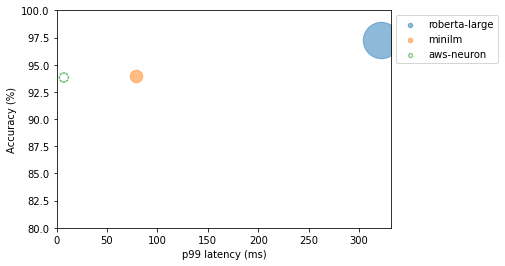

In [1]:
from visualize import plot_metrics
%matplotlib inline

metrics = {
  "roberta-large": {"time_p99_ms": 322, "accuracy": 0.9729,"size_mb":1322},
  "minilm": {"time_p99_ms": 79, "accuracy": 0.9400,"size_mb":156},
  "aws-neuron": {"time_p99_ms": 6, "accuracy": 0.9390,"size_mb":108},
  }

plot_metrics(metrics, "aws-neuron")